<h1>Multi-label text classification:- </h1>

<h3>Classifying legal cases into the types of article violations </h3>

<h5> Name: - Yash Desai
<h5> GitHub:- https://github.com/yash-td


In [131]:
#importing all the necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings


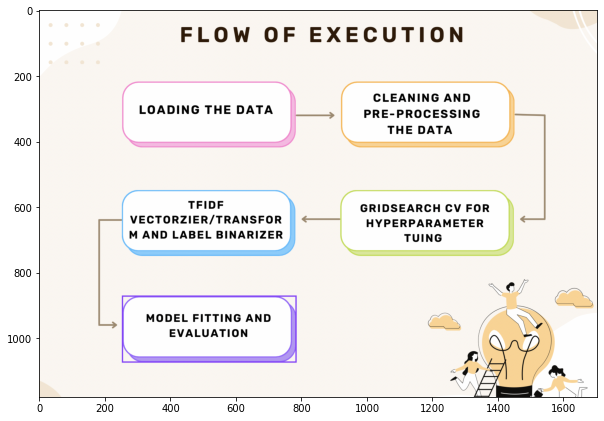

In [158]:
image = plt.imread("pipeline.png")
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [5]:
# downloading the dataset
dataset = load_dataset("lex_glue",'ecthr_a')

Reusing dataset lex_glue (/Users/ytkd/.cache/huggingface/datasets/lex_glue/ecthr_a/1.0.0/c3c0bd7433b636dc39ae49a84dc401190c73156617efc415b04e9835a93a7043)
100%|██████████| 3/3 [00:00<00:00, 227.87it/s]


In [6]:
# getting the train and the test dataset from the main dataset
train = dataset['train']
test = dataset['test']

In [111]:
# creating helper functions

'''
--> pre_process: creating a pre-process funciton which will take the data, perform the following operations and return features and labels
separately: 

1) Convert everything to lower case
2) Remove Stopwords
3) Tokenize the sentences (Also Removing punctuatios and non alpha numeric characters)
4) Lemmatize the words
5) Stemming the words

All these operations are performed using the NLTK package in python.

--> create_corpus : This function is used to convert our entire training data (after the pre-processing) into a corpus of words

--> convert_2d: This funciton is written to covert the 3-dimensional data into 2 dimensional.
After pre-processing we have a list of lists of lists. But labels we have are the violation of articles and are present for
every document and not every sentence. Hence the desired format we need to train the model is a list of lists. Where one
list is the entrie training data of size 9000 and the second list (list of list) is the documents inside the main list of 9000.
'''

def pre_process(data):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    new_data = []
    new_labels = []
    for i in range(len(data)):
        tokenized = [tokenizer.tokenize(entry.lower()) for entry in data[i]['text'] if entry not in stopwords.words('english') and len(entry)>1]
        lemmatized = [[lemmatizer.lemmatize(token) for token in sent] for sent in tokenized]
        stemming = [[stemmer.stem(token) for token in sent] for sent in lemmatized]
        new_data.append(stemming)
        new_labels.append(data[i]['labels'])
    print('Lower Case + Tokenization + Stop Words Remowal + Only Alphanumeric (Removing Punctuation) + Lemmatization + Stemming',stemming[0])
    return new_data, new_labels

def create_corpus(data):
    corpus = []
    for doc in data:
        for sen in doc:
            for word in sen:
                corpus.append(word)
    return corpus   

def convert_2d(data):
    lst2 = []
    for i in data:
        lst1 = []
        for j in i:
            for k in j:
                lst1.append(k)
        lst2.append(lst1)
    return lst2

def identity_tokenizer(text):
    return text



In [112]:
# pre-processing the train and the test data
train_X, train_y  = pre_process(train) 
test_X, test_y = pre_process(test)

Lower Case + Tokenization + Stop Words Remowal + Only Alphanumeric (Removing Punctuation) + Lemmatization + Stemming ['4', 'the', 'applic', 'wa', 'born', 'in', '1971', 'and', 'life', 'in', 'péc', 'he', 'had', 'been', 'practis', 'a', 'a', 'lawyer']
Lower Case + Tokenization + Stop Words Remowal + Only Alphanumeric (Removing Punctuation) + Lemmatization + Stemming ['5', 'the', 'applic', 'were', 'born', 'in', '1965', '1977', 'and', '1976', 'respect']


In [113]:
# creating the corppus using the helper funtion that was created
corpus_train  = create_corpus(train_X)
corpus_test = create_corpus(test_X)
total_corpus = corpus_train+corpus_test

In [114]:
'''
converting the 3 dimentional dataset obtained after tokenization, to a two dimensional set becasue we have 
labels (None, 1 or more than 1) for each document and not each sentence.
'''
train_X_2d = convert_2d(train_X)
test_X_2d = convert_2d(test_X)

In [118]:
'''
Using the tfidf vectorizer from sklearn, converting our train sets and test sets (words) to vectors based on the term
frequency inverse document frequency technique. It assigns a value to a term according to its importance in a document
scaled by its importance across all documents in our corpus, which mathematically eliminates naturally occurring words
in the English language, and selects words that are more descriptive of our text.  
'''
warnings.filterwarnings("ignore")
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)
tfidf.fit(total_corpus)
vectors_train = tfidf.fit_transform(train_X_2d)
vectors_test = tfidf.transform(test_X_2d)

In [29]:
# creating a binarizer to convert all the labels into a binary representation suitable for multilabel classifiers 
# There are 10 unique labels in the dataset (0,1,2,3,4,5,6,7,8,9)
binarizer = MultiLabelBinarizer()
train_y_enc = binarizer.fit_transform(train_y)
test_y_enc = binarizer.transform(test_y)

Below is an example of how a Multilabel binarizer works. For the 9th document in the test dataset articles 3 and 4 were violated. The label binarizer will create a binary representation with the size equal to the total number of unique labels which is 10 in our case. This is done in order for the classifers to interpret the multiple labels in a single instance.

In [30]:
print('Articles violated in the 9th document of the test dataset are ',test_y[8])
print('After applying Multi Label Binarizer',list(test_y_enc[8]))

Articles violated in the 9th document of the test dataset are  [3, 4]
After applying Multi Label Binarizer [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


In [122]:
'''
Creating a pipeline for testing 5 text classification models and reporting their accuracies. Further out of these the best model will be chosen and a hyperparameter
tuning will be performed using the GridSearchCV
'''

classification_models = [
                         OneVsRestClassifier(LinearSVC(), n_jobs=-1),
                         RandomForestClassifier(n_jobs=-1),
                         OneVsRestClassifier(naive_bayes.MultinomialNB()),
                         OneVsRestClassifier(DecisionTreeClassifier()),
                         LabelPowerset(LinearSVC(),
                         )
                         ]

model_scores = []
for model in classification_models:
  # Pipeline object is created to perform model training and evaluate the performance of each model.
  model_pipeline = Pipeline([('model_training', model)])
  model_pipeline.fit(vectors_train, train_y_enc)

  model_name = model
  if model_name=='SVC' and model.kernel=='rbf': 
    model_name+='RBF kernel'
  
  model_scores.append((model_name,(f'{100*model_pipeline.score(vectors_test, test_y_enc):.2f}%')))

# Create the dataframe for score of each model
df_model_scores = pd.DataFrame(model_scores,columns=['Classification Model','Accuracy Score'])
df_model_scores.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classification Model,Accuracy Score
4,"LabelPowerset(classifier=LinearSVC(), require_...",56.00%
0,"OneVsRestClassifier(estimator=LinearSVC(), n_j...",50.30%
3,OneVsRestClassifier(estimator=DecisionTreeClas...,35.60%
1,"(DecisionTreeClassifier(max_features='sqrt', r...",31.80%
2,OneVsRestClassifier(estimator=MultinomialNB()),25.40%


In [135]:
df_model_scores.to_csv('./results.csv')

In [138]:
# Performing a GridSearch for 3 different classifiers to be used with Label Powerset as the best accuracy was found with label 
# powerset SVC. 
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [10, 20, 50],
    },

    {
        'classifier': [LinearSVC()],
        'classifier__C':[1,10,100,1000],
    },

    
]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy')
clf.fit(vectors_train, train_y_enc)

print (clf.best_params_, clf.best_score_)

{'classifier': LinearSVC(C=1), 'classifier__C': 1} 0.643


In [139]:
#using the classifier with the best accuracy
classifier = LabelPowerset(LinearSVC(C=1))
# classifier = OneVsRestClassifier(GradientBoostingClassifier())
from sklearn.metrics import accuracy_score
classifier.fit(vectors_train,train_y_enc)
predictions = classifier.predict(vectors_test)
print('Accuracy of the Label Powerset model with Linear SVC is',accuracy_score(predictions, test_y_enc)*100,'%')
class_report = classification_report(test_y_enc, predictions)
print(class_report)

Accuracy of the Label Powerset model with Linear SVC is 56.00000000000001 %
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        56
           1       0.81      0.80      0.80       189
           2       0.80      0.64      0.71       166
           3       0.65      0.81      0.72       299
           4       0.66      0.41      0.51       123
           5       0.50      0.20      0.29         5
           6       0.69      0.45      0.55        77
           7       0.85      0.59      0.70        37
           8       0.50      0.12      0.20        16
           9       0.72      0.66      0.69       122

   micro avg       0.72      0.68      0.70      1090
   macro avg       0.70      0.56      0.60      1090
weighted avg       0.73      0.68      0.69      1090
 samples avg       0.64      0.60      0.61      1090



In [140]:
# creating a multilabel confusion matrix
classification_matrix = multilabel_confusion_matrix(test_y_enc, predictions)

In [149]:
'''
Method to print the classification matrix and other evaluation metrics

'''

def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[0][0]
    FN = conf_matrix[0][1]
    FP = conf_matrix[1][0]
    TN = conf_matrix[1][1]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

Class 0
True Positives: 934
True Negatives: 48
False Positives: 8
False Negatives: 10
--------------------------------------------------
Accuracy: 0.98
Mis-Classification: 0.02
Sensitivity: 0.99
Specificity: 0.86
Precision: 0.86
f_1 Score: 0.92
Class 1
True Positives: 775
True Negatives: 151
False Positives: 38
False Negatives: 36
--------------------------------------------------
Accuracy: 0.93
Mis-Classification: 0.07
Sensitivity: 0.96
Specificity: 0.8
Precision: 0.8
f_1 Score: 0.87
Class 2
True Positives: 807
True Negatives: 107
False Positives: 59
False Negatives: 27
--------------------------------------------------
Accuracy: 0.91
Mis-Classification: 0.09
Sensitivity: 0.97
Specificity: 0.64
Precision: 0.64
f_1 Score: 0.77
Class 3
True Positives: 573
True Negatives: 242
False Positives: 57
False Negatives: 128
--------------------------------------------------
Accuracy: 0.81
Mis-Classification: 0.19
Sensitivity: 0.82
Specificity: 0.81
Precision: 0.81
f_1 Score: 0.81
Class 4
True Po

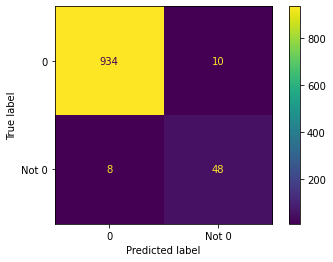

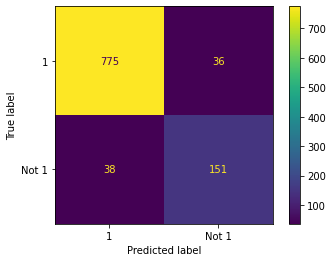

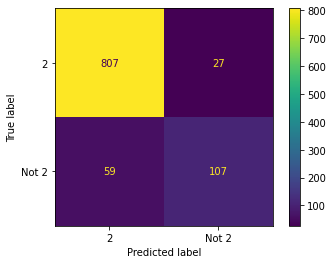

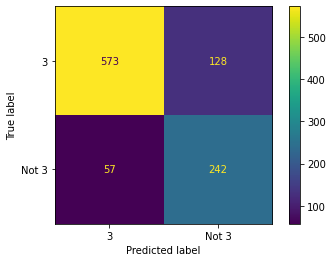

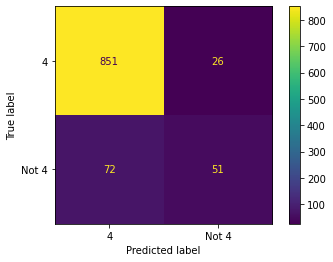

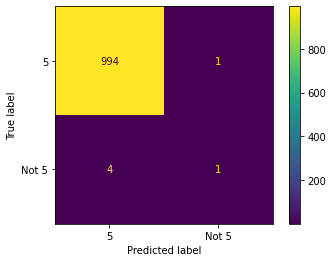

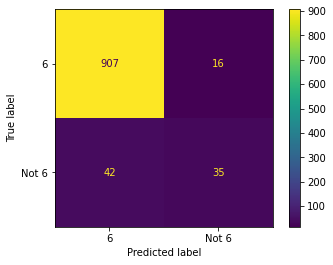

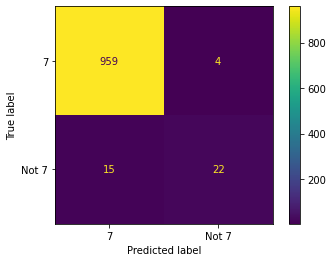

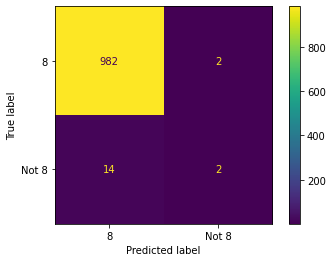

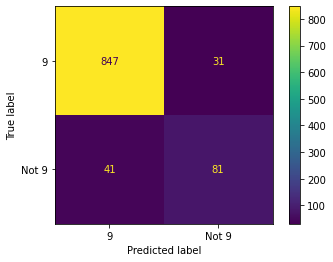

In [157]:
# printing the classification matrix to visualise the true positives, false positives, true negatives and, false negatives for all the
# classes
for i in range(len(classification_matrix)):
    disp = ConfusionMatrixDisplay(confusion_matrix=classification_matrix[i],display_labels=[i,f'Not {i}'])
    disp.plot()
    print('Class',i)
    confusion_metrics(classification_matrix[i])

Discussion:- 

This was a task of multilabel classification where a classifier model was trained with 9000 cases and tested on 1000 cases. The total number of unique labels (aticle violations) were 10 (0,1,2,3,4,5,6,7,8,9). For each case there were one, none or more than one violations. Hence I used a multi label binarizer so that the classifiers could interpret the multiple labels for each cases. To extract the features I used a TFIDF transformer and a vectorizer which considers the inverse document frequencey of all the words from the entire corpus. Five different classification models were fitted to our data and further a grid search cv was performed for the model with the best accuracy to further improve the performance.

It may seem that the accuracies of individual class prediction is very high but for the entire classifier is low. This is because there are a lot of cases where more tha one article is violated. Hence for the classifier to count the entire instance as True Positive all the violations need to match. The indivual accuries from the confusion matrix show that how well the violations of individual class is predicted. For example:- The classifier predicts if the article 2 is violated or not wiht a 93% accuracy and a f1 score of 0.87. The overall accuracy of the classifier is 56% with a weighted average f1 score of 0.69. 